https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

## Goal

In this chapter, We will understand the concepts behind Harris Corner Detection.

We will see the following functions: cv.cornerHarris(), cv.cornerSubPix()

![nn](./harris_a.png)
![nn](./harris_b.png)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

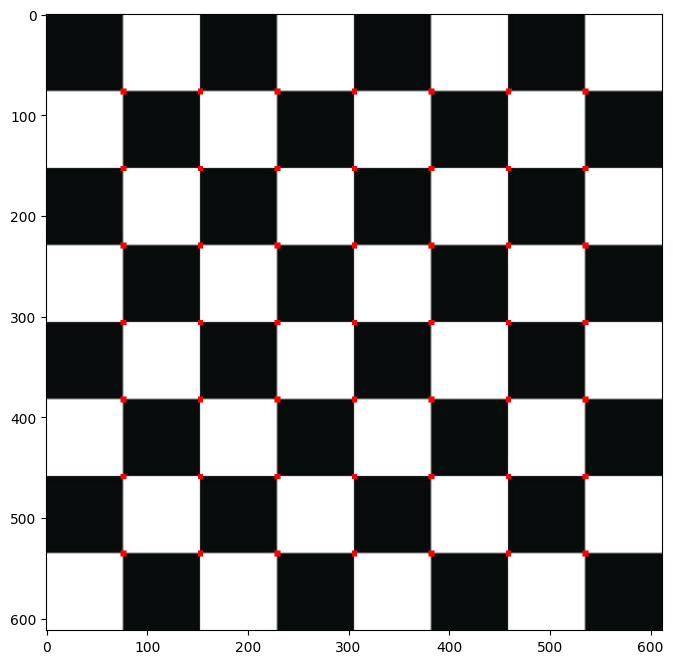

In [2]:
filename = '../data/chessboard.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)
# Thresholding for an optimal value, it may vary depending on the image.
img[dst>0.01 * dst.max()] = [0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:, ::-1])
plt.show()

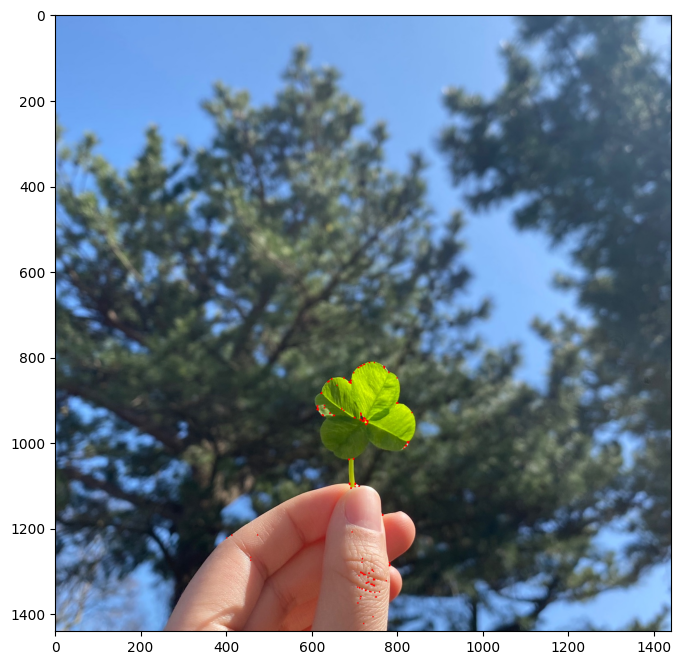

In [3]:
# run your own image
filename= '../data/image.jpeg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)
# Thresholding for an optimal value, it may vary depending on the image.
img[dst>0.01 * dst.max()] = [0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:, ::-1])
plt.show()

## Using Kornia library

https://kornia.readthedocs.io/en/latest/_modules/kornia/feature/responses.html

In [4]:
import torch
from torchvision import transforms
import kornia.feature as KF

from PIL import Image

In [5]:
filename = '../data/chessboard.jpg'

tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)

print(tensor.shape)

torch.Size([1, 1, 612, 612])


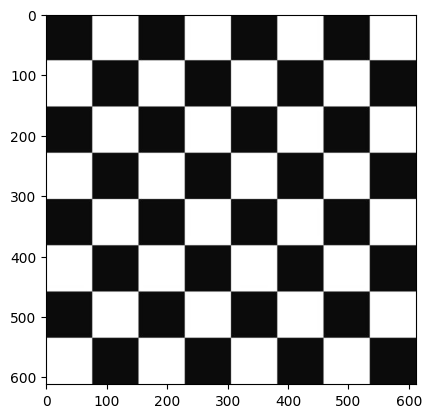

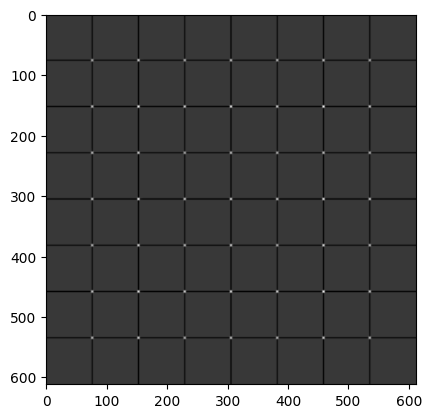

In [6]:
plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

harris = KF.responses.CornerHarris(0.05)

cornerness = harris(tensor)

plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()

## (심화) Example on the scale pyramid

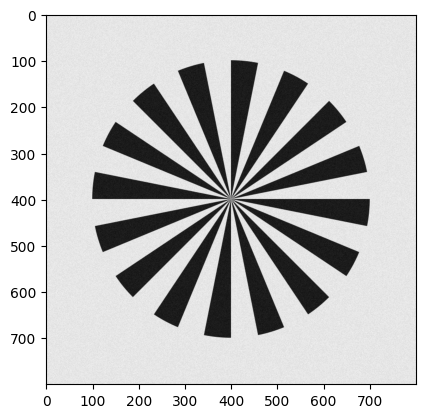

In [9]:
import kornia
import kornia.geometry as KG
from kornia import tensor_to_image as tti

# ScalePyramid create spyramid of blurred and downsamples images
SP = KG.ScalePyramid(3, 1.0, 10)

filename = '../data/siemens.png'
# filename = './data/image.jpeg'

img = Image.open(filename)
timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255. / 255.
# This specific image somehow has [0, 255*2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

7 torch.Size([1, 1, 6, 800, 800])


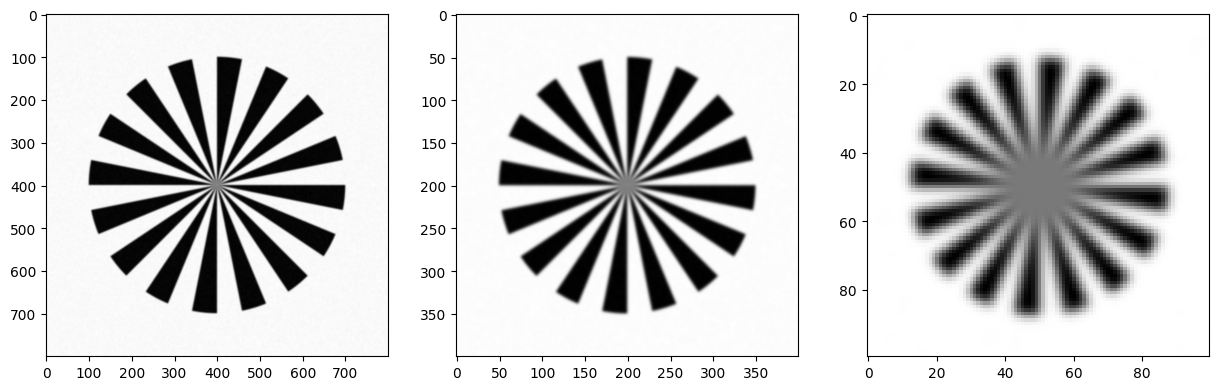

In [10]:
resp = KF.responses.CornerHarris(0.05)

SP = KG.ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP(timg)
print(len(pyr), pyr[0].shape)

fig, axes = plt.subplots(1,3, figsize=(15,8))

axes[0].imshow(tti(pyr[0][0,0,0]), 'gray')
axes[1].imshow(tti(pyr[1][0,0,0]), 'gray')
axes[2].imshow(tti(pyr[3][0,0,0]), 'gray')
current_level=pyr[1]

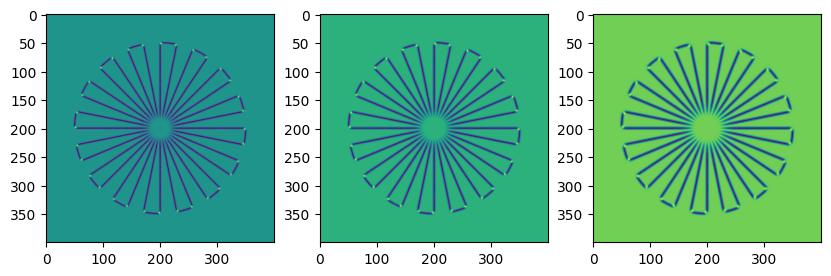

In [11]:
fig, axes = plt.subplots(1,3, figsize=(10,6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0, i]))

In [12]:
## The next component is detector of the maximum of the local responce: ConvQuadInterp3d(), 
## which does quadratic interpolation of the location, or ConvSoftArgmax3d, 
## which does softargmax estimation of the location.

nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

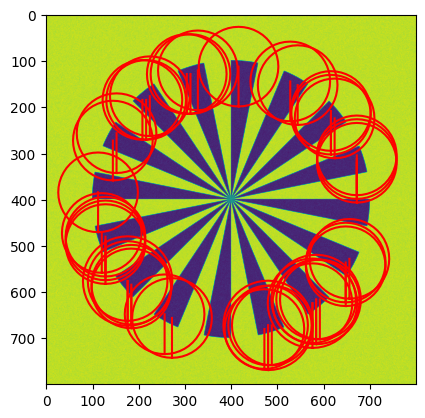

torch.Size([1, 40, 2, 3])


In [13]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

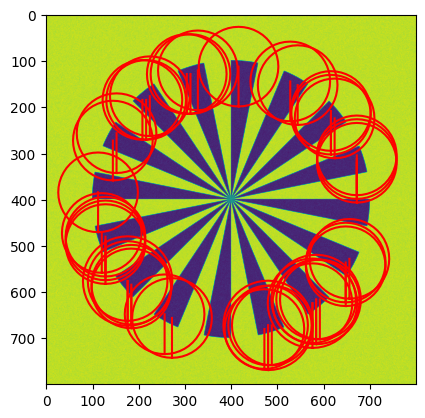

torch.Size([1, 40, 2, 3])


In [14]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width)

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)
print(lafs.shape)

생각보다 duplication 제거가 잘 안된다.

따라서, quadrative interpolation 3D를 통해 subpixel 수준에서의 non-maximal suppression을 한번 더 수행한다.

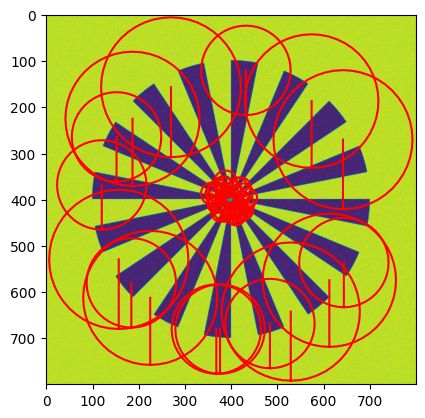

In [15]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4) 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

Harris 가 아니라 다른 affine 모듈 (e.g. DoG 나 LoG를 사용)은 어떻게 될까?

scale-space detector에 shape estimator를 넣어서 실행.


/var/folders/ff/gt7xnldx7fd17_99cwr9mmk00000gn/T/ipykernel_30545/339609120.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


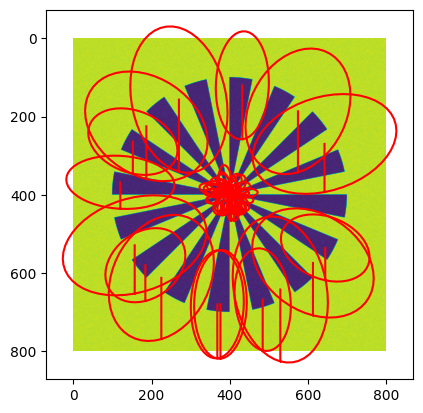

In [16]:
# What about Harris-Affine features?
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

Feature orientation estimator 도 추가 기능

/var/folders/ff/gt7xnldx7fd17_99cwr9mmk00000gn/T/ipykernel_30545/3835569862.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


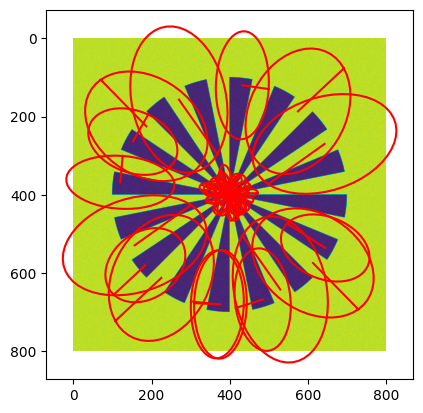

In [17]:
# Now lets also detect feature orientation
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

## Obtain patch descriptor using the obtained affine regions

In [18]:
#Lets describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([0.1356, 0.2002, 0.1509, 0.0619, 0.1622, 0.2002, 0.0959, 0.1546, 0.0283,
        0.1689, 0.0440, 0.0574, 0.0083, 0.0082, 0.0068, 0.0078, 0.1711, 0.0750,
        0.0048, 0.0122, 0.2002, 0.0162, 0.0298, 0.0840, 0.0418, 0.1459, 0.0740,
        0.1153, 0.0095, 0.0120, 0.0124, 0.0065, 0.0418, 0.0072, 0.0207, 0.0489,
        0.0244, 0.0037, 0.0404, 0.0694, 0.1054, 0.2002, 0.1361, 0.1061, 0.0079,
        0.0096, 0.0095, 0.0085, 0.0152, 0.0693, 0.1514, 0.2002, 0.0059, 0.0241,
        0.1853, 0.1298, 0.0807, 0.0503, 0.1184, 0.0094, 0.0073, 0.0088, 0.0078,
        0.0057, 0.1056, 0.2002, 0.1699, 0.0532, 0.1513, 0.1697, 0.2002, 0.0236,
        0.1447, 0.0716, 0.1035, 0.0062, 0.0111, 0.0105, 0.0101, 0.0073, 0.2002,
        0.1246, 0.0132, 0.0053, 0.1015, 0.1089, 0.0055, 0.0029, 0.0719, 0.0396,
        0.0064, 0.0091, 0.0101, 0.0091, 0.0124, 0.0106, 0.0437, 0.0051, 0.0027,
        0.0722, 0.0230, 0.0019, 0.0023, 0.0032, 0.0041, 0.0025, 0.0056, 0.0124,
        0.0069,

### Reference 

https://kornia.readthedocs.io/en/latest/feature.html

https://github.com/kornia/kornia-examples/blob/master/local_feature_detection_example.ipynb